In [9]:
import torch
import numpy as np
from transformers import AutoModelForSequenceClassification, BertTokenizer
from datasets import load_dataset
from tqdm import tqdm

from sklearn.metrics import ConfusionMatrixDisplay, f1_score

__load data__

In [2]:
# corpus = load_dataset('merionum/ru_paraphraser', data_files='plus.jsonl')
corpus = load_dataset('merionum/ru_paraphraser')

Using custom data configuration merionum--ru_paraphraser-e39dafb2b050eb83
Found cached dataset json (/home/avagadro/.cache/huggingface/datasets/merionum___json/merionum--ru_paraphraser-e39dafb2b050eb83/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab)


  0%|          | 0/2 [00:00<?, ?it/s]

__load model__

In [3]:
# load model

model_name = 'cointegrated/rubert-base-cased-dp-paraphrase-detection'
model = AutoModelForSequenceClassification.from_pretrained(model_name).cuda()
tokenizer = BertTokenizer.from_pretrained(model_name)


def compare_texts(text1, text2):
    batch = tokenizer(text1, text2, return_tensors='pt').to(model.device)
    with torch.inference_mode():
        proba = torch.softmax(model(**batch).logits, -1).cpu().numpy()
    return proba[0] # p(non-paraphrase), p(paraphrase)

__process__

In [4]:
PART = 'train'

predicts = []
pbar = tqdm(zip(corpus[PART]['text_1'], corpus[PART]['text_2']), total=corpus.num_rows[PART], desc='processing')

for bundle in pbar:
    predicts.append(compare_texts(*bundle)[1])

target = [int(v) if v != '-1' else 0 for v in corpus['train']['class']]

processing: 100%|██████████| 7227/7227 [01:04<00:00, 112.32it/s]


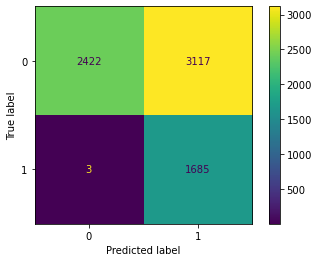

In [8]:
ConfusionMatrixDisplay.from_predictions(target, np.array(predicts) > 0.5)

In [11]:
f1_score(target, np.array(predicts) > 0.5)

0.5192604006163329

In [ ]:
#